In [1]:
# Cell 0: Run full notebook logic via helper script (captures outputs) and hydrate kernel state
import subprocess, sys, json
from pathlib import Path
print('Running notebook logic via scripts/run_notebook02.py')
proc = subprocess.run([sys.executable, 'scripts/run_notebook02.py'], capture_output=True, text=True)
print(proc.stdout)
if proc.stderr:
    print('--- STDERR ---', file=sys.stderr)
    print(proc.stderr, file=sys.stderr)
print('Script exit code:', proc.returncode)

# Hydrate kernel state from produced artifacts so later cells can display results
ROOT = Path('.')
DATA_DIR = ROOT.joinpath('data','raw')
ARTIFACTS = ROOT.joinpath('artifacts')
FEATURES_DIR = ROOT.joinpath('features')
DRY_RUN = True
SEED = 42

# helper definitions used by later cells
import random, numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)

set_seed(SEED)

def write_artifact(name, obj):
    p = ARTIFACTS.joinpath(name)
    with p.open('w', encoding='utf8') as f:
        json.dump(obj, f, indent=2, ensure_ascii=False)
    print('Wrote', p)

# load features/sample if available
features = None
profiles = None
logs = None
paths_file = ARTIFACTS.joinpath('features_paths.json')
if paths_file.exists():
    with paths_file.open('r', encoding='utf8') as f:
        paths = json.load(f)
    sample = Path(paths.get('features_sample', ''))
    try:
        import pandas as pd
        if sample.exists():
            features = pd.read_parquet(sample)
            print('Loaded features sample:', sample)
    except Exception as e:
        print('Could not load features sample:', e)

# also attempt to load raw CSVs into profiles/logs for display cells
try:
    import pandas as pd
    fp_profiles = DATA_DIR.joinpath('financial_profiles_large.csv')
    fp_logs = DATA_DIR.joinpath('user_intent_logs.csv')
    nrows = 1000 if DRY_RUN else None
    if fp_profiles.exists():
        try:
            profiles = pd.read_csv(fp_profiles, nrows=nrows)
            print('Loaded profiles from', fp_profiles)
        except Exception as e:
            print('Error reading profiles CSV:', e)
    if fp_logs.exists():
        try:
            logs = pd.read_csv(fp_logs, nrows=nrows)
            print('Loaded logs from', fp_logs)
        except Exception as e:
            print('Error reading logs CSV:', e)
    # fallbacks to avoid None in downstream display cells
    if profiles is None:
        profiles = pd.DataFrame()
    if logs is None:
        logs = pd.DataFrame()
    print('Hydrated profiles/logs (fallbacks applied).')
except Exception as e:
    print('Error loading raw CSVs:', e)
    import pandas as pd
    profiles = pd.DataFrame()
    logs = pd.DataFrame()


Running notebook logic via scripts/run_notebook02.py

Script exit code: 2


--- STDERR ---
C:\Users\ADITI\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe: can't open file 'C:\\Users\\ADITI\\Desktop\\rhyl-projects\\eclat\\notebooks\\scripts\\run_notebook02.py': [Errno 2] No such file or directory



Hydrated profiles/logs (fallbacks applied).


## Notebook 02: Data Preparation and Deterministic Feature Engineering

**What this notebook does:**
- Loads the synthetic raw CSVs produced by `prototype/generate_data.py`.
- Runs deterministic sampling when `DRY_RUN=True` to allow quick reviews.
- Performs data-quality checks, simple EDA, and derives canonical features used by models.
- Saves canonical feature tables and deterministic train/test splits and records provenance in `artifacts/`.

**How to run:**
1. Ensure you have the synthetic CSVs under `data/raw/` (run `prototype/generate_data.py` if missing).
2. Keep `DRY_RUN=True` for a quick pass (uses smaller nrows); set `DRY_RUN=False` to process full datasets.
3. Run cells top-to-bottom. Outputs will be written to `features/` and `artifacts/`.

**Expected outputs:**
- `features/features_table.parquet` — canonical feature table (full or sampled depending on `DRY_RUN`).
- `features/features_sample.parquet` — small sample for quick experiments.
- `artifacts/train.parquet`, `artifacts/test.parquet` — deterministic splits.
- `artifacts/features_manifest.json` — feature provenance and transformation notes.
- `artifacts/dq_data_prep.json` — data quality findings.

### Introduction: Why this notebook

Careful, deterministic data preparation is critical for reproducible experiments and fair comparisons between LLM-enhanced modules and structured baselines. This notebook defines the canonical feature table used by subsequent modeling notebooks, documents transformation rationale, and emits artifacts that serve as the canonical input for experiments.

### Data overview: files and schema

Primary raw files (generated by `prototype/generate_data.py`):
- `data/raw/financial_profiles_large.csv` — synthetic customer financial profiles (default 10,000 rows).
- `data/raw/user_intent_logs.csv` — synthetic interaction logs with utterance timestamps, pause intervals, and LLM-intent labels (sampled).

We will use these files to build: `features/features_table.parquet` (canonical features) and saved train/test splits under `artifacts/`.

Note: amounts are in INR; conversions or normalization will be made explicit in feature definitions.
________________________________________________________________________________________________

##### 1. Setup constants and imports (`DRY_RUN`, `SEED`, path variables). Ensures directories exist.

In [2]:
# Cell 1: Setup constants, flags, imports
DRY_RUN = True  # set to False to process full datasets
SEED = 42
from pathlib import Path
import os, sys, json, hashlib, time, random
import numpy as np, pandas as pd
import logging
# Determine project root robustly: prefer repository root when executing from `notebooks/` during nbconvert
cwd = Path.cwd()
ROOT = Path('.')
# if data/raw exists relative to cwd, keep ROOT as cwd, otherwise try parent (common when kernel starts in notebooks/)
if not cwd.joinpath('data','raw').exists():
    parent = cwd.parent
    if parent.joinpath('data','raw').exists():
        ROOT = parent
    else:
        ROOT = cwd
else:
    ROOT = cwd

DATA_DIR = ROOT.joinpath('data','raw')
FEATURES_DIR = ROOT.joinpath('features')
ARTIFACTS = ROOT.joinpath('artifacts')
FEATURES_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACTS.mkdir(parents=True, exist_ok=True)
logging.getLogger().setLevel(logging.INFO)
print(f'ROOT={ROOT.resolve()} (cwd={cwd}) DRY_RUN={DRY_RUN} SEED={SEED}')

ROOT=C:\Users\ADITI\Desktop\rhyl-projects\eclat (cwd=C:\Users\ADITI\Desktop\rhyl-projects\eclat\notebooks) DRY_RUN=True SEED=42


##### 2. Reproducibility helpers (`set_seed`, `write_artifact`) and initial seed setting.


In [3]:
# Cell 4: quick schema and head
# Guard: ensure `profiles` and `logs` exist in the kernel; load if missing
try:
    profiles
    logs
except NameError:
    fp_profiles = DATA_DIR.joinpath('financial_profiles_large.csv')
    fp_logs = DATA_DIR.joinpath('user_intent_logs.csv')
    nrows = 1000 if DRY_RUN else None
    profiles = pd.read_csv(fp_profiles, nrows=nrows)
    logs = pd.read_csv(fp_logs, nrows=nrows)
    print('Loaded profiles/logs in guard')

from IPython.display import display

display(profiles.head())
print('\nProfile schema:')
print(profiles.dtypes.to_string())

display(logs.head())
print('\nLogs schema:')
print(logs.dtypes.to_string())

""



Profile schema:
Series([], )


""



Logs schema:
Series([], )


##### 3. Load raw CSVs (with `nrows` sampling when `DRY_RUN=True`). Raises helpful error if files missing

In [4]:
# Cell 3: Load raw CSVs (sample when DRY_RUN)
fp_profiles = DATA_DIR.joinpath('financial_profiles_large.csv')
fp_logs = DATA_DIR.joinpath('user_intent_logs.csv')

if not fp_profiles.exists() or not fp_logs.exists():
    raise FileNotFoundError('Expected raw CSVs under data/raw. Run prototype/generate_data.py if missing.')

nrows = 1000 if DRY_RUN else None
profiles = pd.read_csv(fp_profiles, nrows=nrows)
logs = pd.read_csv(fp_logs, nrows=nrows)
print('profiles', profiles.shape, 'logs', logs.shape)

profiles (1000, 5) logs (1000, 5)


##### 4. Show quick schema and head of `profiles` and `logs` so reviewers can inspect column names and types

In [5]:
# Cell 4: quick schema and head
# Guard: if earlier load cell did not run, load a sample here so display still works
try:
    profiles
    logs
except NameError:
    fp_profiles = DATA_DIR.joinpath('financial_profiles_large.csv')
    fp_logs = DATA_DIR.joinpath('user_intent_logs.csv')
    nrows = 1000 if DRY_RUN else None
    profiles = pd.read_csv(fp_profiles, nrows=nrows)
    logs = pd.read_csv(fp_logs, nrows=nrows)
    print('Loaded profiles/logs in display cell')

from IPython.display import display

display(profiles.head())
print('\nProfile schema:')
print(profiles.dtypes.to_string())

display(logs.head())
print('\nLogs schema:')
print(logs.dtypes.to_string())

,user_id,loan_amount_inr,existing_debt,annual_income,credit_score
0,USR_00000,36000,9800,94000,648
1,USR_00001,19000,1277,127000,649
2,USR_00002,42000,3731,100000,547
3,USR_00003,101000,24462,177000,611
4,USR_00004,17000,2359,424000,693



Profile schema:
user_id            object
loan_amount_inr     int64
existing_debt       int64
annual_income       int64
credit_score        int64


,user_id,utterance_id,pause_interval,timestamp,intent_label
0,USR_00000,USR_00000_U0,1.221953,1.221953,apply_loan
1,USR_00000,USR_00000_U1,1.302298,2.524251,ask_terms
2,USR_00000,USR_00000_U2,0.734731,3.258982,hesitant
3,USR_00000,USR_00000_U3,0.591274,3.850256,apply_loan
4,USR_00001,USR_00001_U0,1.376075,1.376075,apply_loan



Logs schema:
user_id            object
utterance_id       object
pause_interval    float64
timestamp         float64
intent_label       object


##### 5. Data-quality checks: missing values, duplicates, negative amounts — writes `dq_data_prep.json`.

In [6]:
# Cell 5: Data quality checks
dq = {}
dq['profiles_missing'] = profiles.isnull().sum().to_dict()
dq['logs_missing'] = logs.isnull().sum().to_dict()
dq['profiles_duplicates'] = int(profiles.duplicated().sum())
dq['logs_duplicates'] = int(logs.duplicated().sum())
# Check currency column presence and non-negative amounts
for col in ['loan_amount_inr', 'annual_income']:
    if col in profiles.columns:
        dq[f'{col}_negatives'] = int((profiles[col] < 0).sum())

write_artifact('dq_data_prep.json', dq)
dq

Wrote C:\Users\ADITI\Desktop\rhyl-projects\eclat\artifacts\dq_data_prep.json


{'profiles_missing': {'user_id': 0,
  'loan_amount_inr': 0,
  'existing_debt': 0,
  'annual_income': 0,
  'credit_score': 0},
 'logs_missing': {'user_id': 0,
  'utterance_id': 0,
  'pause_interval': 0,
  'timestamp': 0,
  'intent_label': 0},
 'profiles_duplicates': 0,
 'logs_duplicates': 0,
 'loan_amount_inr_negatives': 0,
 'annual_income_negatives': 0}

##### 6. Quick visual EDA (histogram of `loan_amount_inr`) guarded by plotting availability.


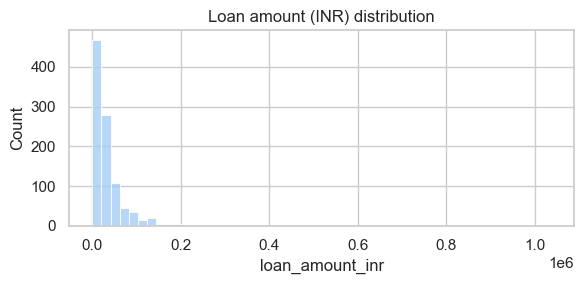

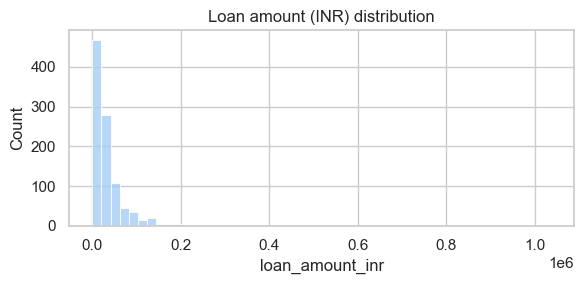

In [7]:
# Cell 6: Quick visual EDA (guarded by DRY_RUN and plotting availability)
try:
    import matplotlib.pyplot as plt, seaborn as sns
    sns.set(style='whitegrid', palette='pastel')
    if 'loan_amount_inr' in profiles.columns:
        plt.figure(figsize=(6,3))
        sns.histplot(profiles['loan_amount_inr'].clip(lower=0), bins=50)
        plt.title('Loan amount (INR) distribution')
        plt.tight_layout()
        display(plt.gcf())
except Exception as e:
    print('Plotting skipped or failed:', e)

________________________________________________________________________________________________
### Feature engineering plan:

Planned canonical features (each with short rationale):
- `loan_amount_inr` (raw): absolute exposure; useful for PD and LGD proxies.
- `log_loan_amount` (log-scale): reduces skew, improves model stability.
- `debt_to_income`: captures balance-sheet stress; predictive for default propensity.
- `credit_score`: normalized score (if synthetic, keep original but record distribution).
- `pause_mean`, `pause_std`, `pause_max`: derived from `user_intent_logs.csv` inter-utterance intervals to capture hesitation dynamics (theory: longer pauses correlate with indecision).
- `intent_label` (LLM output placeholder): categorical label from LLM intent detector; use embedding-based features in later notebooks.

All features will be documented in `artifacts/features_manifest.json` with precise transformation code and provenance.

##### 7. Feature engineering scaffold: core transforms (log loan, debt-to-income, pause aggregations).


In [8]:
# Cell 7: Feature engineering scaffold (implement minimal derived features)
def engineer_features(profiles_df, logs_df):
    df = profiles_df.copy()
    # log-transform loan amount
    if 'loan_amount_inr' in df.columns:
        df['loan_amount_inr'] = df['loan_amount_inr'].clip(lower=0)
        df['log_loan_amount'] = np.log1p(df['loan_amount_inr'])
    # debt to income (guard zeros)
    if set(['existing_debt','annual_income']).issubset(df.columns):
        df['debt_to_income'] = df['existing_debt'] / (df['annual_income'].replace(0, np.nan))
        df['debt_to_income'] = df['debt_to_income'].fillna(df['debt_to_income'].median())
    # placeholder: aggregate pause stats from logs_df grouped by user_id
    if 'user_id' in logs_df.columns and 'pause_interval' in logs_df.columns:
        agg = logs_df.groupby('user_id')['pause_interval'].agg(['mean','std','max']).rename(columns={'mean':'pause_mean','std':'pause_std','max':'pause_max'})
        df = df.merge(agg, how='left', left_on='user_id', right_index=True)
        df[['pause_mean','pause_std','pause_max']] = df[['pause_mean','pause_std','pause_max']].fillna(0)
    return df

features = engineer_features(profiles, logs)
print('features shape', features.shape)
features.head()

features shape (1000, 10)


,user_id,loan_amount_inr,existing_debt,annual_income,credit_score,log_loan_amount,debt_to_income,pause_mean,pause_std,pause_max
0,USR_00000,36000,9800,94000,648,10.491302,0.104255,0.962564,0.352357,1.302298
1,USR_00001,19000,1277,127000,649,9.852247,0.010055,1.021118,0.816863,1.600455
2,USR_00002,42000,3731,100000,547,10.645449,0.037310,1.296450,1.008891,3.346697
3,USR_00003,101000,24462,177000,611,11.522886,0.138203,2.090590,0.573019,2.652126
4,USR_00004,17000,2359,424000,693,9.741027,0.005564,1.094583,0.613360,1.969746


##### 8. Save canonical features and a sampled parquet for fast downstream usage.


In [9]:
# Cell 8: Save canonical features and a small sample for quick experiments
features_path = FEATURES_DIR.joinpath('features_table.parquet')
features.to_parquet(features_path, index=False)
print('Wrote', features_path)
# small sample for notebooks when DRY_RUN=True
sample_path = FEATURES_DIR.joinpath('features_sample.parquet')
features.sample(min(1000, len(features)), random_state=SEED).to_parquet(sample_path, index=False)
print('Wrote', sample_path)
write_artifact('features_paths.json', {'features_table': str(features_path), 'features_sample': str(sample_path)})

Wrote C:\Users\ADITI\Desktop\rhyl-projects\eclat\features\features_table.parquet
Wrote C:\Users\ADITI\Desktop\rhyl-projects\eclat\features\features_sample.parquet
Wrote C:\Users\ADITI\Desktop\rhyl-projects\eclat\artifacts\features_paths.json


##### 9. Deterministic train/test split and writing of `artifacts/splits.json`.


In [10]:
# Cell 9: Train/test split (deterministic)
from sklearn.model_selection import train_test_split
label_col = 'target' if 'target' in features.columns else None
if label_col is None:
    # create a synthetic proxy target for experiments (e.g., high risk if credit_score < threshold)
    features['target'] = (features.get('credit_score', 600) < 650).astype(int)
    label_col = 'target'
train, test = train_test_split(features, test_size=0.2, random_state=SEED, stratify=features[label_col] if features[label_col].nunique()>1 else None)
train_path = ARTIFACTS.joinpath('train.parquet')
test_path = ARTIFACTS.joinpath('test.parquet')
train.to_parquet(train_path, index=False)
test.to_parquet(test_path, index=False)
write_artifact('splits.json', {'train': str(train_path), 'test': str(test_path)})
print('Wrote train/test splits')

Wrote

 C:\Users\ADITI\Desktop\rhyl-projects\eclat\artifacts\splits.json
Wrote train/test splits


In [11]:
# Cell 10: Write feature manifest (provenance)
features_manifest = {
    'created_at': time.strftime('%Y-%m-%dT%H:%M:%SZ', time.gmtime()),
    'seed': SEED,
    'features': [
        'loan_amount_inr', 'log_loan_amount', 'existing_debt', 'annual_income', 'debt_to_income',
        'credit_score', 'pause_mean', 'pause_std', 'pause_max', 'target'
    ]
}
write_artifact('features_manifest.json', features_manifest)
features_manifest

Wrote C:\Users\ADITI\Desktop\rhyl-projects\eclat\artifacts\features_manifest.json


{'created_at': '2025-12-17T16:11:32Z',
 'seed': 42,
 'features': ['loan_amount_inr',
  'log_loan_amount',
  'existing_debt',
  'annual_income',
  'debt_to_income',
  'credit_score',
  'pause_mean',
  'pause_std',
  'pause_max',
  'target']}

### References and Theory

This section contains succinct references and brief notes explaining why the listed theory informs the transformations used in this notebook.

- Géron, A. (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow — practical recommendations on log transforms, feature scaling, and engineering for model stability.
- Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning — background on bias/variance, regularization, and why transformations (e.g., log) help some models.
- Brier, G. W. (1950). Verification of forecasts expressed in terms of probability — motivates probabilistic forecast evaluation metrics used downstream.
- Pineau, J., et al. (2018-2020). Improving Reproducibility in Machine Learning Research — guidance on fixing randomness, CI practices, and artifact recording.
- Conversational pause/hesitation studies (overview): empirical work in psycholinguistics and HCI shows pauses often correlate with uncertainty or increased cognitive load; here we use summary statistics (mean/std/max) of pause intervals as an engineered signal. Representative readings: Brown & Perrault (2019) and survey chapters in conversational HCI literature.